In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
figsizen = plt.rcParams['figure.figsize'] = (40,10)
plt.rcParams.update({'font.size':22})

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

from sklearn.datasets import load_iris
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

#  Importere datasettet

#### Bruker datasettet til én av de fire spillerne vi har valgt ut

In [2]:
spiller1 = '../Spiller1.csv'
data = pd.read_csv(spiller1, sep=',')
data.head(5)

,Date,Fatigue,Mood,Readiness,Sleep Durhation,Sleep Quality,Soreness,Stress
0,2020-03-20,3.0,3.0,7.0,9.0,3.0,3.0,2.0
1,2020-03-21,3.0,3.0,6.0,8.0,3.0,2.0,3.0
2,2020-03-22,3.0,3.0,6.0,9.0,3.0,3.0,4.0
3,2020-03-23,3.0,3.0,7.0,9.0,4.0,3.0,3.0
4,2020-03-24,3.0,3.0,6.0,9.0,3.0,2.0,3.0


# Datasett med full tidsperiode 


In [3]:
data = data[['Date', 'Readiness']]

# Etter at dataen er importert, må den prepareres

#### Her velger vi ut kun 'Readiness' som parameter, og tar med oss datoene i tillegg.

#### Deretter vil vi konvertere 'Date'-kolonnen til datetime, og setter videre dette som index. For sikkerhets skyld blir frekvensen satt til 'D' (daglig). 
#### Datasett fra 21.03.2020 til 31.12.2021

In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')
data = data.asfreq('D')
data = data.sort_index()
data = data.loc['2020-03-21':]
#data = data.loc['2020-03-21': '2021-06-20']     
data

,Readiness
Date,
2020-03-21,6.0
2020-03-22,6.0
2020-03-23,7.0
2020-03-24,6.0
2020-03-25,8.0
...,...
2021-12-27,3.0
2021-12-28,4.0
2021-12-29,5.0



#### Datasettet har en del manglende verdier, og disse tomme verdiene blir fylt med en metode kalt 'ffill'. Det vil si at kolonnen med manglende verdi blir fylt inn med verdien fra foregående dag. 

#### Etter det summerer vi antall rader som har null verdier


In [5]:
data['Readiness'] = data['Readiness'].fillna(method='ffill')

In [6]:
print('Number of rows with missing values:', data['Readiness'].isnull().sum())

Number of rows with missing values: 0


# --------------------------------------------------------
# Dummy Modell: Regressor
#### Vi deler opp datasettet i X oy y verdier og velger å ha 80% treningssett og 20% testsett for dummy regressoren

In [7]:
X = pd.DataFrame(data) 
y = pd.DataFrame(data['Readiness']) 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [9]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

DummyRegressor()

In [10]:
dummy_predicted= dummy.predict(y_test)
dummy_predicted

array([7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461538,
       7.03461538, 7.03461538, 7.03461538, 7.03461538, 7.03461

In [11]:
dummy.score(X_train, y_train)

0.0

## Dummy Test Error
#### Dummy regressor sin MSE og R2 score Test error

In [12]:
error_mse_dummy = mean_squared_error(
                y_true = y_test,
                y_pred = dummy_predicted
            )
print(f"MSE test error for Dummy: {error_mse_dummy}")

MSE test error for Dummy: 2.071485952391707


In [13]:
error_r2_score_dummy = r2_score(
                y_true = y_test,
                y_pred = dummy_predicted
            )
print(f"R2 Score test error for Dummy: {error_r2_score_dummy }")

R2 Score test error for Dummy: -0.0015995274708127116


# --------------------------------------------------------


# Treningssett og testsett
#### Dele datasettet i trenings og testsett
#### Vi bruker 131 dager (steps = 131) som test for å evaluere den predektive kapasiteten til modellen som tilsvarer 20% av datasettet

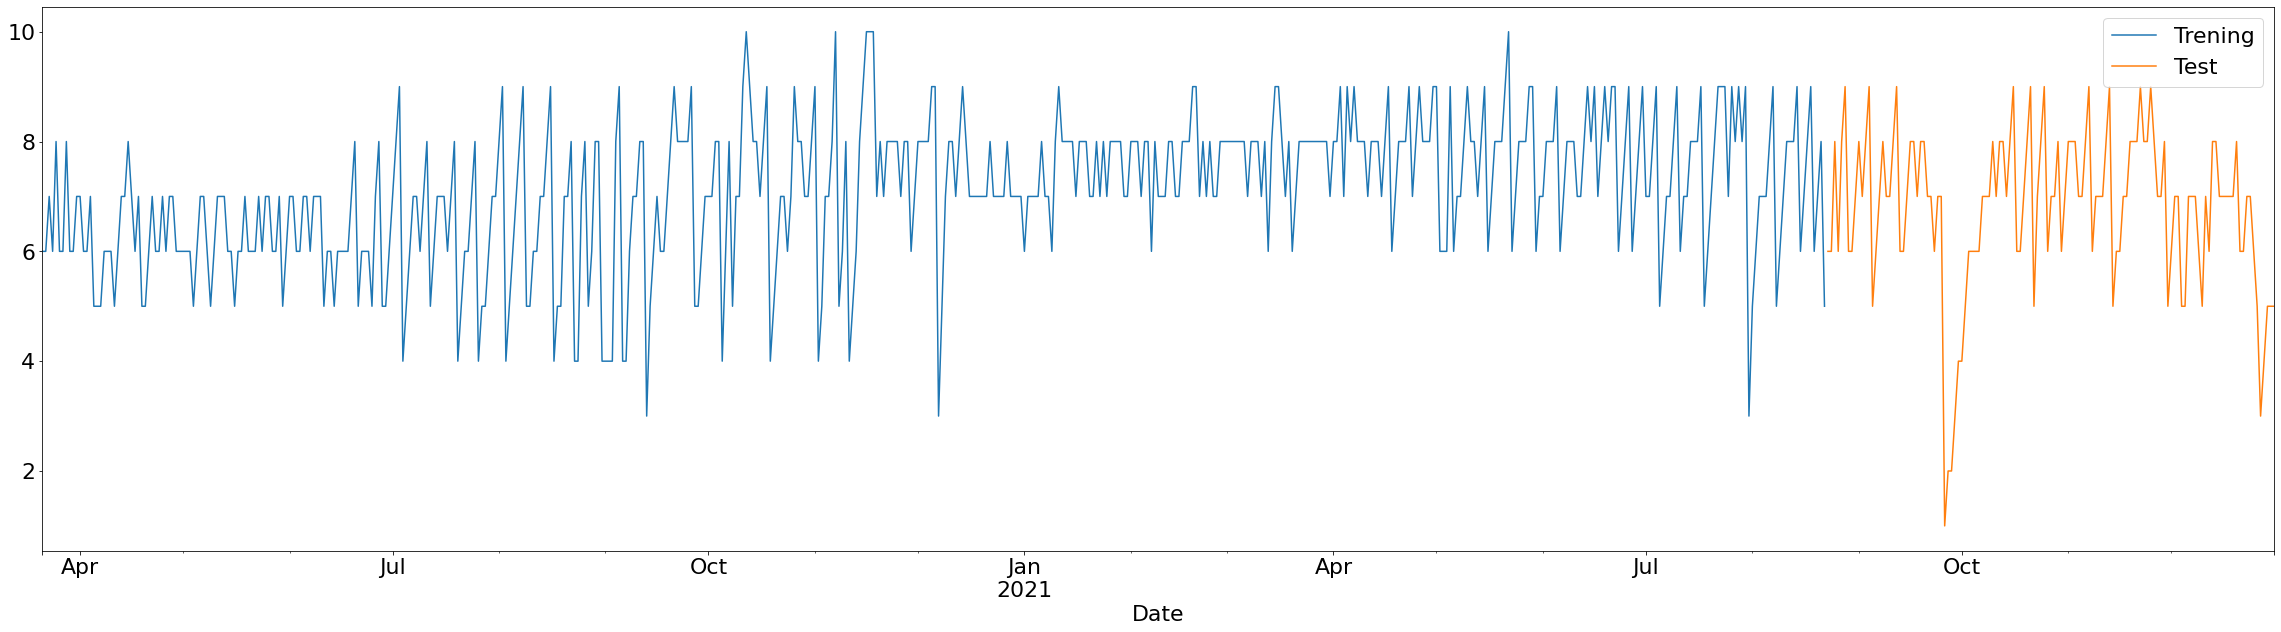

In [14]:
steps= 131 

data_train = data[:-steps]
data_test  = data[-steps:]
plt.rcParams.update({'font.size':22})
fig, ax=plt.subplots(figsize=figsizen)
ax.set_facecolor((1,1,1))
plt.rcParams.update({'font.size':22})
data_train['Readiness'].plot(label='Trening')
data_test['Readiness'].plot( label='Test')
ax.legend();
plt.show()

# Lage og trene Forecaster
#### Med ForecasterAutoreg blir en modell lags og trent med Random Forest regressor
#### Vi bruker et tidsvindu av 3 dager (lags = 3) for å predikere de neste

In [15]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 3
               
             )
forecaster.fit(y=data_train['Readiness'])

# Prediksjon
#### Etter at modellen ble trent, blir test daten prediktet med 131 dager inn i fremtiden

In [16]:
steps = 131
predictions = forecaster.predict(steps=steps)   

predictions = pd.Series(data=predictions, index=data_test['Readiness'].index)
predictions

Date
2021-08-23    5.725655
2021-08-24    6.993020
2021-08-25    7.125572
2021-08-26    7.001666
2021-08-27    7.059090
                ...   
2021-12-27    7.059090
2021-12-28    7.059090
2021-12-29    7.059090
2021-12-30    7.059090
2021-12-31    7.059090
Freq: D, Name: pred, Length: 131, dtype: float64

Spiller1


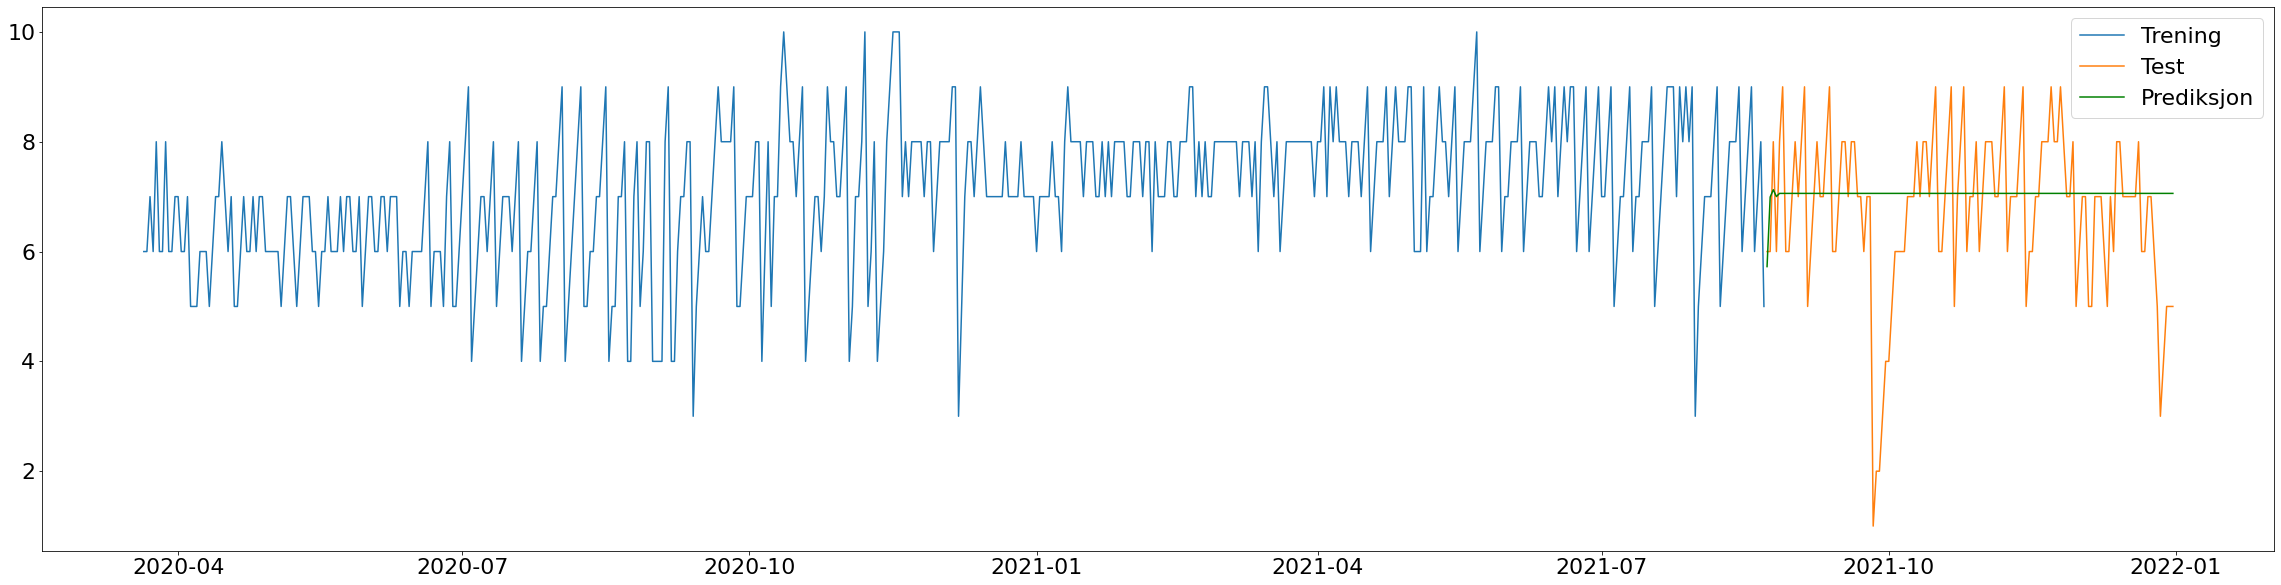

In [17]:
fig, ax = plt.subplots(figsize=figsizen)
plt.plot(data_train['Readiness'],label='Trening')
plt.plot(data_test['Readiness'], label='Test')
plt.plot(predictions, label='Prediksjon', color='green')

ax.set_facecolor((1,1,1))
print("Spiller1")
ax.legend();
plt.show()

# Prediksjon error i testsett
#### Vi benytter oss av MSE og R2 Score test errorne (som i dummy modell) for å se hvor bra modellen presterer

In [18]:
error_mse_prediksjon = mean_squared_error(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")

MSE test error for prediksjon: 2.2419845907397637


In [19]:
error_r2_score_prediksjon = r2_score(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

R2 score test error for prediksjon: -0.035379374641686834


In [20]:
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")

print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

MSE test error for prediksjon: 2.2419845907397637
R2 score test error for prediksjon: -0.035379374641686834


# Hyperparameter tuning
#### Vi vet ikke om valg av lag = 3 er det beste, derfor har vi en funkskon som heter grid_search_forecaster som vil finne beste lags, antall trær innad RF og lengden fra rotnode til terminalnoden

In [21]:
steps = 131
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3  # Placeholder, the value will be overwritten
             )

param_grid = {'n_estimators': [100, 500], # Number of trees to be used in the forest
              'max_depth': [3, 5, 10]}  # Length of the longest path from a root to a leaf,  
 
lags_grid = [3,10]   # Lists of lags to try. Only used if forecaster is an instance of ForecasterAutoreg
results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Readiness'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps, # change steps
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best        = True,
                        verbose            = False
)

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:07<00:00, 33.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.3015751155256465



## Ut i fra Forecaster sin grid_search_forecaster er 3 lags, 3 node nivåer og 500 trær er den mest optimale for datasettet og modellen

In [22]:
results_grid.head(5)

,lags,params,metric,max_depth,n_estimators
3,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 500}",1.301575,5,500
2,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",1.329065,5,100
4,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",1.397275,10,100
5,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 500}",1.406240,10,500
1,"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 500}",1.419663,3,500


# Endelig  modell
### Endrer til  3 lags, 3 node nivåer og 500 trær

In [23]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123) #must change the inputs to the outputs of hyperparamter tuning

forecaster2 = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3    
             )

forecaster2.fit(y=data_train['Readiness'])

### Endelig prediksjon

In [24]:
predictions = forecaster.predict(steps=steps)
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(10)

Date
2021-08-23    5.758868
2021-08-24    7.113749
2021-08-25    7.072871
2021-08-26    7.101209
2021-08-27    7.282138
2021-08-28    7.282138
2021-08-29    7.282138
2021-08-30    7.282138
2021-08-31    7.282138
2021-09-01    7.282138
Freq: D, Name: pred, dtype: float64

Spiller1


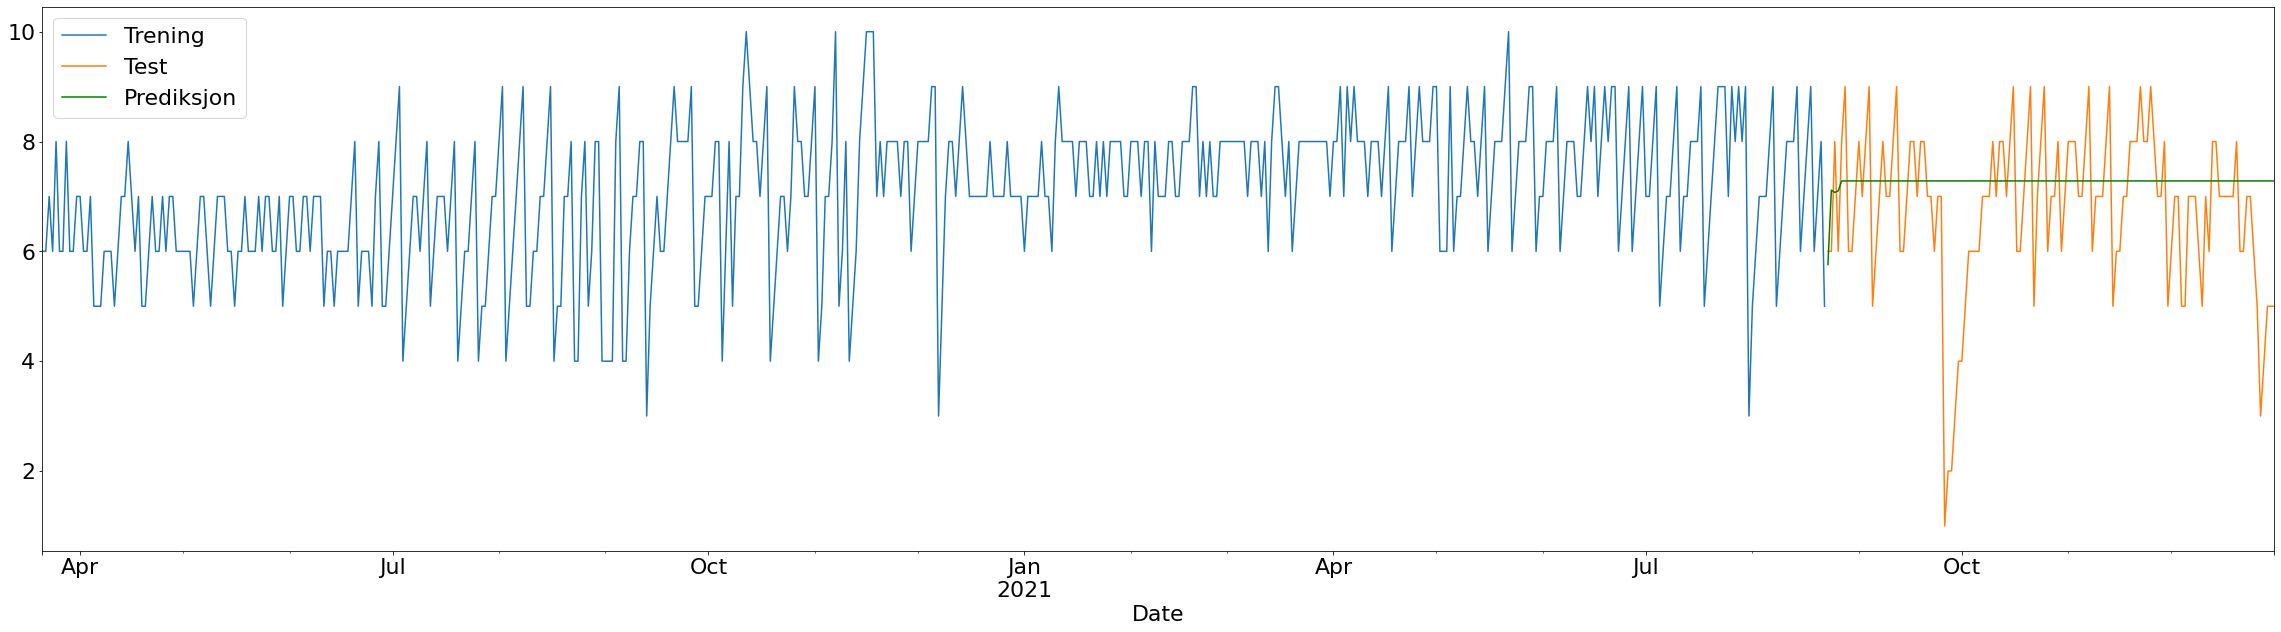

In [25]:
fig, ax = plt.subplots(figsize=figsizen)
data_train['Readiness'].plot(ax=ax, label='Trening')
data_test['Readiness'].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Prediksjon', color='green')
plt.rcParams.update({'font.size':22})
ax.set_facecolor((1,1,1))
ax.legend();
print('Spiller1')

### Endelig prediksjon sin MSE og R2 score Test error

In [26]:
error_mse_prediksjon_hyper = mean_squared_error(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"MSE test error for prediksjon: {error_mse_prediksjon_hyper}")

MSE test error for prediksjon: 2.418658440986441


In [27]:
error_r2_score_prediksjon_hyper = r2_score(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

R2 score test error for prediksjon: -0.035379374641686834



# Alle test errors

In [28]:
# Alle Errors:

#Dummy 
print("Spiller1:")
print(f"MSE test error for Dummy: {error_mse_dummy}")
print(f"R2 Score test error for Dummy: {error_r2_score_dummy }")

print("--------------------")
print("Spiller1:")
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")
print(f"MSE test error for prediksjon med hyper tuning: {error_mse_prediksjon_hyper}")
print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

Spiller1:
MSE test error for Dummy: 2.071485952391707
R2 Score test error for Dummy: -0.0015995274708127116
--------------------
Spiller1:
MSE test error for prediksjon: 2.2419845907397637
MSE test error for prediksjon med hyper tuning: 2.418658440986441
R2 score test error for prediksjon: -0.035379374641686834
